# <center> École des Ponts ParisTech</center>
## <center> SPH pour l'hydraulique </center>
### <center> Projet SPH GMM 2021</center>
#### <center> Parois mobiles  </center>
<center> Auteurs : Ruben Persicot & Yohan Lanier </center>


<center> Encadrants : Rémi Carmigniani et Damien Violeau </center>


<img src='./Figures/logo_p.jpg' width=200>


## 2. Ecoulement dans une cavité entrainée

### 2.1 Explication du problème étudié

$\textbf{Description de la configuration}$


Le fluide visqueux est contenu dans une boîte. Trois parois de la boîte sont immobiles, et la quatrième
coulissant le long de sa direction propre, entraîne ainsi le fluide, et crée une circulation à l’intérieur de la
boîte. Il s'agit une configuration académique souvent étudiée dans la littérature scientifique en CFD et pour
laquelle de nombreux résultats sont disponibles, nottament ceux de Ghia et al. en 1982 : https://www.sciencedirect.com/science/article/pii/0021999182900584

L’écoulement est considéré invariant dans une direction i.e. bidimensionnel. La figure 1.1 représente
schématiquement l’écoulement dans la cavité. On considère que les parois avant et arrière (dans le plan
de la feuille d’énoncé) de la boîte sont suffisament éloignées l’une de l’autre pour ne pas avoir d’influence
sur l’écoulement.


$\textbf{Schéma du problème étudié}$

<img src='./Figures/cavity.PNG' width=500>

### 2.2 Etude numérique.

#### Import des fichiers et des modules utiles pour programmer un code SPH.

In [14]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sys import exit
import os.path
from os import path
import csv
import time
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True
from src.spyh import *
from src.checkTD3 import *
from src.sphvar import *
from src.plotParticles import *
from src.state import *
from src.contrib import *
from src.analytical_solutions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Définition des grandeurs du problèmes et du fluide

Les paramètres ci dessous correspondent à un fluide très visqueux puisque la viscosité dynamique est égale à 500 Pa/s.

On note que la gravité n'est pas prise en compte dans notre simulation.

In [15]:
#GEOMETRIC PARAMETERS
L = 1 #Length and width of the cavity (m)
U = 1 # Upper bound velocity (m/s)
#FLUID PARAMETERS
Re = 1 #Reynold's number
rhoF = 1000 #Fluid density
c0 = 40   
mu = rhoF*U*L/Re #Dynamic viscosity (Pa.s)
print(mu)
grav = np.array([0.0, 0.0]) #Gravity (m.s-2)
gamma = 7
B = rhoF*c0**2/gamma 
#DENSITY & SHEPARD THRESHOLDS : 
shepardMin = 10**(-6)
rhoMin = 0.5*rhoF
rhoMax = 1.5*rhoF

1000.0


#### Définition des propriétés des particules

In [16]:
#PARTICLES & SPACES PARAMETERS : 
dr = L/40
h = smthfc*dr
m=dr*dr*rhoF
lspace = 2*h
print(lspace)
#COMPUTATION DOMAIN : 
xOrigin = 0
yOrigin = 0
xSize = L + 2*nBound*dr
ySize = L+2*nBound*dr
xMax = xOrigin+xSize
yMax = yOrigin+ySize

0.1


#### Création du domaine de calcul

Pour notre projet nous avons crée un nouveau type de particules dont le FLAG est MOBILEBOUND. Celles-ci permettent de modéliser le mouvement d'une paroi mobile dont on impose le mouvement. 

Ce nouveau type de particule est défini dans [src/sphvar.py](src/sphvar.py)

Les murs seront composés d'une couche de *nBound =4* particules *fictives*. Ce nombre est suffisant pour éviter la pénétration du mur.

In [17]:
#INIT PART:
part = init_particles()
part = addBox(part,[0,0,xSize,nBound*dr],BOUND,dr,rhoF)#Lower boundary domain
part = addBox(part,[0, nBound*dr, nBound*dr,L], BOUND, dr, rhoF)# Left boundary domain
part = addBox(part,[nBound*dr+L, nBound*dr, nBound*dr,L], BOUND, dr, rhoF) #Right boundary domain 
part = addBox(part,[0, nBound*dr+L, xSize,nBound*dr], MOBILEBOUND, dr, rhoF) #Lid (moving bound) domain
part = addBox(part,[nBound*dr,nBound*dr,L,L],FLUID,dr,rhoF) #Fluid domain

#### Affichage du domaine 

<IPython.core.display.Javascript object>


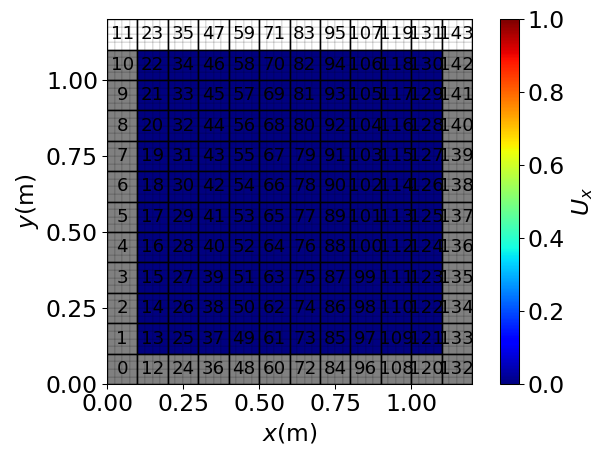

In [18]:
%matplotlib notebook
Umax= 1
tabUx = part[:,VEL[0]]
domain = [xOrigin,xMax,yOrigin,yMax,0,Umax]
plotPropertiesWithBound(part,tabUx,r'$U_x$',domain,dr,1)

#### Affichage des espaces

In [19]:
vecPer = np.array([12*lspace,0])
posSpace,neibSpace,partSpace,listNeibSpace = init_spaces(xOrigin,yOrigin,xSize,ySize,lspace,dr)
plotSpaces(posSpace,'k',lspace,1)

#### Initialisation de la vitesse de la paroi supérieure

In [20]:
part[:,VEL] = initMobileBoundVelocity((part[:,INFO]==MOBILEBOUND), part[:,VEL], U)

In [21]:
part[:,RHO],part[:,VEL] =interpolateBoundaryPeriodicX((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,aW,h,m,B,rhoF,gamma,grav,vecPer[0],shepardMin)

#### Gestion des enregistrements

In [22]:
current_directory = os.getcwd()
case_directory = os.path.join(current_directory, r'Results/Cavity_'+time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(case_directory)
data_directory = os.path.join(case_directory,r'Data')
figures_directory = os.path.join(case_directory,r'Figures')
os.mkdir(data_directory)
os.mkdir(figures_directory)

#### Gestion du pas de temps et des fréquences de sorties des figures

In [23]:
# Here we specify the output frequencies
dt_figure = 0.025*(L/2)**2*rhoF/mu
t_print = 0
#final time :
t_end = 3
t=0
it=0
im_count=0


### 2.3 Simulation SPH

<IPython.core.display.Javascript object>


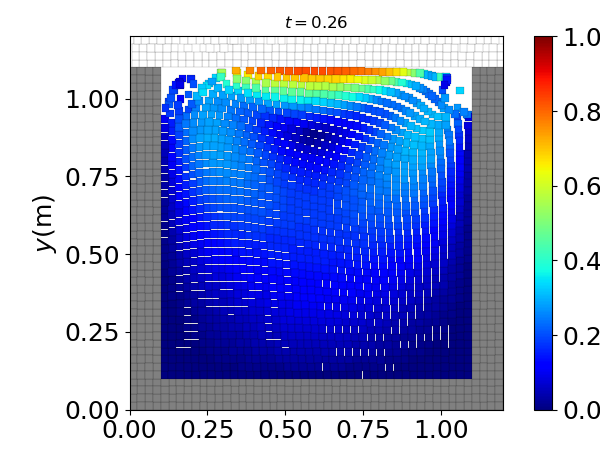

KeyboardInterrupt: 

In [24]:
%matplotlib notebook
while t<t_end:
    #STEP1 : Calcul de la CFL
    dt = CFLConditions(part[:,VEL],h,c0,grav,rhoF,mu)
    #STEP2 : Interpolation des conditions au bord
    part[:,RHO],part[:,VEL] =interpolateBoundary((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,shepardMin)
    #STEP2BIS : Interpolation des conditions au bord sur les mobiles bound
    part[:,RHO], part[:, VEL] = interpolateMobileBoundary((part[:,INFO]==MOBILEBOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     np.array([U, 0.0]),\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,shepardMin)
    #STEP3 : Calcul des forces et des termes de densité
    part[:,FORCES],part[:,DRHODT] = computeForcesMorris((part[:,INFO]==FLUID),\
                                                 part[:,SPID],\
                                                 part[:,POS],\
                                                 part[:,VEL],\
                                                 part[:,RHO],\
                                                 listNeibSpace,\
                                                 aW,h,m,B,rhoF,gamma,grav,mu)
    #STEP4 : Integration en temps
    part[:,POS],part[:,VEL],part[:,RHO] = integrationStep((part[:,INFO]==FLUID),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt)
    #STEP4BIS : integration en temps des particules de la paroi mobile
    part[:,POS], part[:,RHO] = integrationStepPeriodicX_Moving_BoundCavity((part[:,INFO]==MOBILEBOUND),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt,vecPer[0])
    #STEP5 : Corriger densité trop basse
    part[:,RHO] = checkDensity(part[:,RHO],rhoMin,rhoMax)
    #STEP6 : Mise à jour des voisins (pas forcément à tous les pas de temps)
    part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
    listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
    t +=dt
    it +=1
    if t>=t_print:
        #FIGURE 1
        fig = plt.figure(1)
        plt.clf()
        plt.title(r'$t = %2.2f$'%(t))
        velMagn = (part[:,VEL[0]]*part[:,VEL[0]]+part[:,VEL[1]]*part[:,VEL[1]])**.5
        domain = [xOrigin,xMax,yOrigin,yMax,0,1]
        plotPropertiesWithBound(part,velMagn,r'$u/U_0$',domain,dr,1)
        figname = os.path.join(figures_directory,r'vel_%06d.png'%im_count)
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        im_count = im_count+1
        t_print +=dt_figure

### 2.4 Analyse des résultats

Précisons une fois de plus que les codes utilisés lors de ce projet et lors des séances de TD ne semblent adaptés que pour des fluides très visqueux. Nous avons essayé de simuler les configurations pour lesquelles on disposait de données expérimentales, nottament pour $\rho_f=1000 kg.m^{-3}$, $\mu=10^{-3} Pa.s$, $U=1m.s^{-1}$ et $L=1m$. Malheureusement, ces jeux de paramètres ne permettaient pas de mettre en mouvement le fluide dans la cavité. 

Initialement on peut voir que le profil de vitesse est semblable aux profils usuels qui sont caractérisitiques de l'écoulement en cavité entrainée. En effet, on peut voir ci-dessous un profil de vitesse généré à partir du logiciel $\textit{Code_ Saturne}$ pour  $\rho_f=1000 kg.m^{-3}$, $\mu=10^{-3} Pa.s$, $U=1m.s^{-1}$ et $L=1m$.

<img src='./Figures/cavity_SATUR.PNG' width=500>

Néanmoins, au fur et à mesure que la simulation progresse on remarque que le fluide se "décolle" des parois aux coins. Il s'agit d'un problème que nous n'avons pas du résoudre. 


Etant donné que l'on disposait déjà d'un cas test permettant de valider notre code, nous avons préféré nous concentrer sur la programmation d'intéractions avec d'autres parois mobiles. 

C'est l'objet de la troisième partie du projet, dans laquelle on se propose de simuler l'écoulement induit par la chute d'un solide : [Floating_solid](Floating_solid.ipynb)